In [112]:
#Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, f1_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm, datasets
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Define project goal

Optimize the prediction of the count of bike rentals during given hours based on a variety of features.
Do so by feature engineering and try the effect of polynomial features.

## 1. Data exploration

In [4]:
# Read in data

In [5]:
df = pd.read_csv("../data/biketrain.csv", parse_dates=True)

In [6]:
dft = pd.read_csv("../data/biketest.csv", parse_dates=True)

In [7]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
df_train = df.copy()

In [9]:
#Reset index to datetime
df_train.set_index([pd.to_datetime(df['datetime'])], inplace = True)
df_train.drop(['datetime'], axis =1, inplace = True)

In [11]:
#Check for missing values
df_train.isnull().values.any()

False

In [12]:
#Inspect 'count' column
df_train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

<AxesSubplot:>

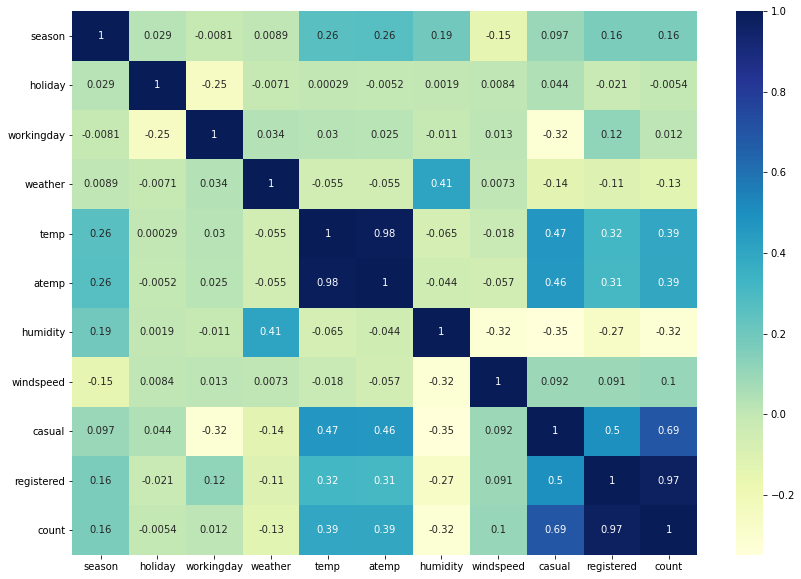

In [13]:
#Look at correlation matrix to get initial overview of features
plt.figure(figsize=(14,10))
sns.heatmap(df_train.corr(),
           cmap = 'YlGnBu',
           annot = True)

###### Observations:
    - Seasons seem to have less impact on bike rents than expected
    - temp has a slightly higher correlation with registered customers, therefore atemp is dropped
    
Features effect casual and registered customers count differently. Analyze further and potentially
predict individually with separate models.
    
   

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>, <AxesSubplot:>]],
      dtype=object)

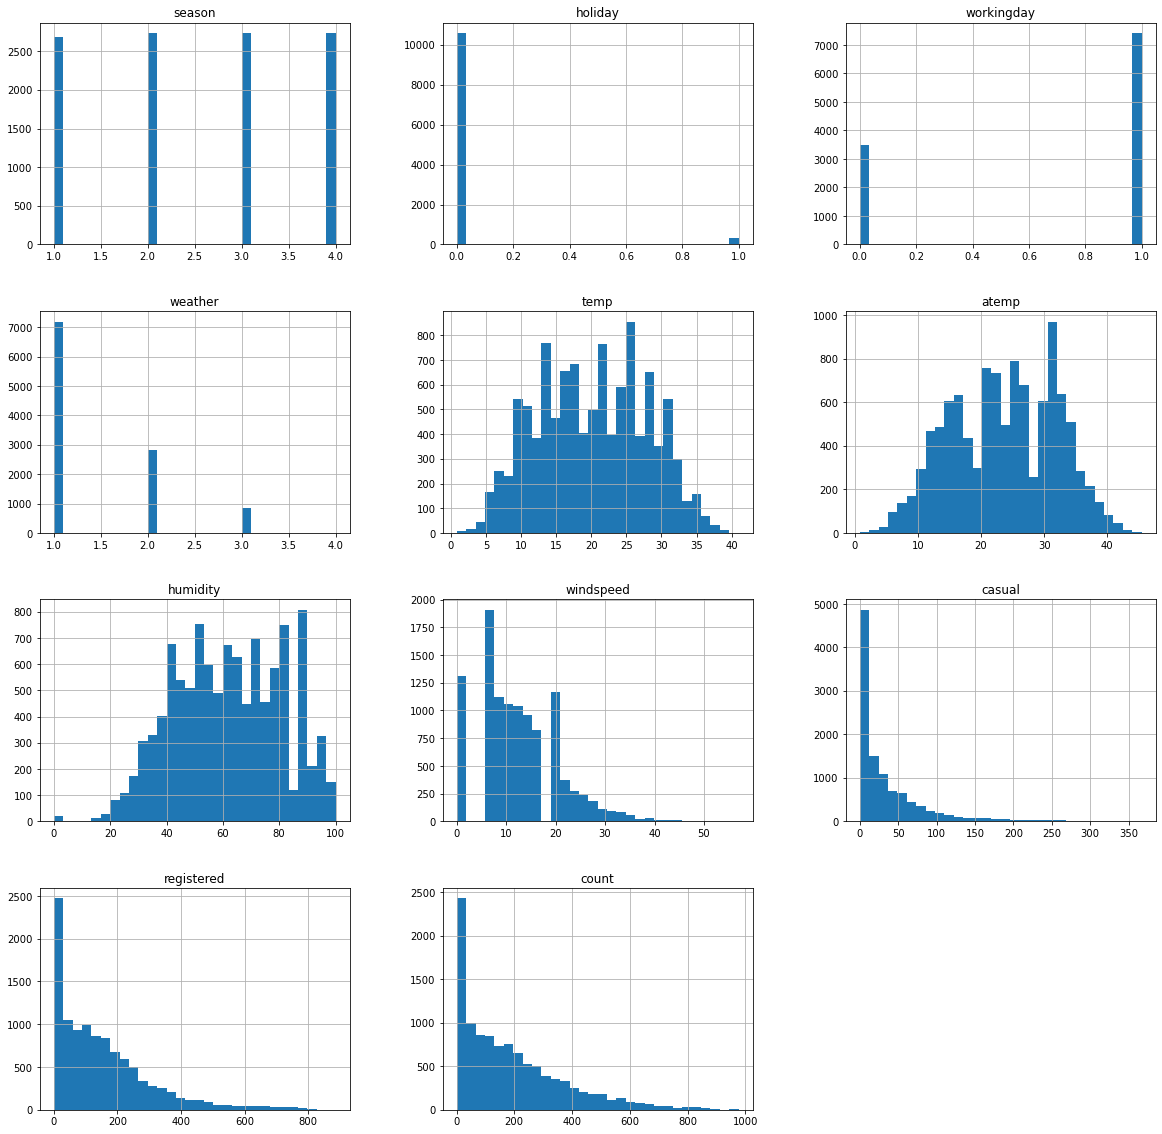

In [217]:
#Examine distributions (of interval features)
df_train.hist(bins=30,figsize=(20,20))

<AxesSubplot:xlabel='datetime'>

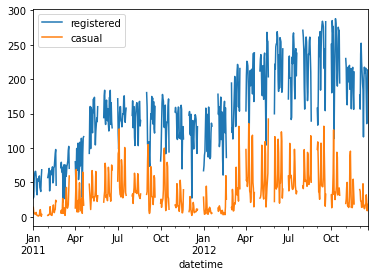

In [219]:
#Examine distinction between casual and registered customers
df_meanday = df_train.resample('1D').mean()
df_meanday.plot(y = ['registered', 'casual'])

The gaps between the values are the values of the test set not included in the training set at the end of each month.
There might be seasonal differences between registered and casual customers

<AxesSubplot:xlabel='season'>

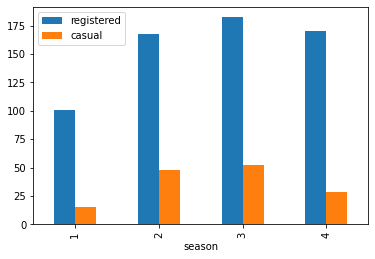

In [220]:
df_train.groupby(['season']).mean().plot.bar(y = ['registered', 'casual'])

Difference doesnt seem to be seasonal...

<AxesSubplot:xlabel='temp'>

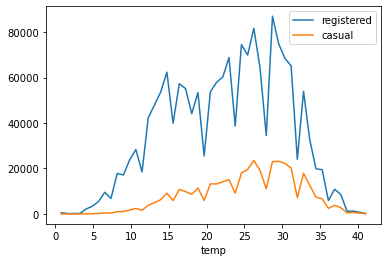

In [222]:
df_train.groupby(['temp']).sum().plot(y = ['registered', 'casual'])

<AxesSubplot:xlabel='holiday'>

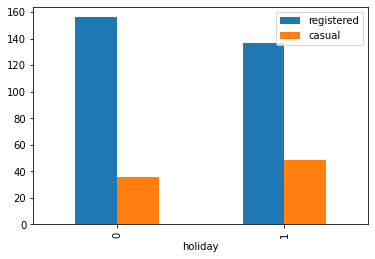

In [223]:
#Examine holiday behavior
df_train.groupby(['holiday']).mean().plot.bar(y = ['registered', 'casual'])

Holiday and temperature seem to have different effects on registered vs. casual users. 
Not strong enough to justify a seperate calculation at first glance.

## 2. Base model

In [16]:
def linreg(features,y):
    """
    Creates linear regression with features given as a list. Since it is not a classification problem, Kaggle's metric "RMSLE" will be used
    """
    #Train/test split
    Xlin = df_train[features]
    ylin = df_train[y]
    ylog = np.log1p(ylin) #log+1 to optimize model against RMSLE used by Kaggle
 
    #The test set doesnt include count values, therefore we use the sklearn train-test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xlin, ylog, random_state=69)
    lr = LinearRegression().fit(Xtrain, ytrain)
    ypredlog = lr.predict(Xlin)
    ypred = np.exp(ypredlog)-1 #to bring back predictions to original scale
    print("RMSLE score test:", np.sqrt(mean_squared_log_error(ylin, ypred)))
    
    #As train scores have been producing overflow errors and tend to be close to test scores for linear regression, they are not shown

In [17]:
features = ['temp','humidity','season','windspeed','weather','holiday','workingday']
linreg(features,'count')

RMSLE score test: 1.220541950978978


## 3. Feature engineering

In [18]:
#Add hours to create new features
df_train['hour']= df_train.index.hour

In [19]:
#   Differentiate between day and night and add this as a new one-hot encoded feature
df_train['daytime'] = np.where( ( (df_train['hour'] < 6 )| (df_train['hour'] >22) ), "Night", "Day")


In [20]:
#Bikes might be used for commuting therefore add 'commuting'-feature as True between 0600 and 0900 & 1700 and 1900 
df_train['commute'] = np.where( ( (df_train['hour'] > 5 )& (df_train['hour'] <10) ) |  ((df_train['hour'] > 16) & (df_train['hour'] <20)) ,1, 0)

In [21]:
#Initially seasons where divided by months of 1y, rearrange for meteorological seasons which also represent the warmest and coldest seasons
df_train['month']= df_train.index.month

conditions = [
    (df_train['month'] <3) | (df_train['month'] == 12),
    (df_train['month'] >2) & (df_train['month'] < 6),
    (df_train['month'] >5) & (df_train['month'] < 9),
    (df_train['month'] >8) & (df_train['month'] < 12)
]
choices = [1,2,3,4]

df_train['season_new']= np.select(conditions, choices)
features.remove('season')

In [22]:
#One-hot encoding 
df_train[['w1','w2','w3','w4']] = pd.get_dummies(df_train['weather'])
df_train[['s1','s2','s3','s4']] = pd.get_dummies(df_train['season_new'])
df_train[['Day','Night' ]] = pd.get_dummies(df_train['daytime'])

df_train.drop(columns = ["w4","s4","Day","month",'atemp','daytime'], inplace = True)

In [23]:
#add new features to features list
features.extend(['w1','w2','w3','s1','s2','s3','commute','Night'])
features.remove('weather')

In [24]:
features

['temp',
 'humidity',
 'windspeed',
 'holiday',
 'workingday',
 'w1',
 'w2',
 'w3',
 's1',
 's2',
 's3',
 'commute',
 'Night']

##### Scaling

In [25]:
# Use MinMax scaler for linear features
scaler = MinMaxScaler()

In [26]:
df_train["temp"] = scaler.fit_transform(df_train[["temp"]])
df_train["humidity"] = scaler.fit_transform(df_train[["humidity"]])
df_train["windspeed"] = scaler.fit_transform(df_train[["windspeed"]])

In [27]:
linreg(features,'count')

RMSLE score test: 0.8277304826795482


## 4. Feature expansion and regularization

In [33]:
#adding polynomias features
pl = PolynomialFeatures(degree=2, include_bias=True)
lr = LinearRegression()
pipeline = make_pipeline(pl,lr)

X1 = df_train[features]
y1 = df_train['count']
y1log = np.log1p(y1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1log, random_state=69)

pipeline.fit(Xtest,ytest)

ypred = pipeline.predict(X1)
ypred[ypred<0] = ypred[ypred>0].min() #used as intermediate shortcut for unusual but possible negative values
print("RMSLE score:", np.sqrt(mean_squared_log_error(y1, ypred)))

RMSLE score: 3.1504432071334114


*Drop in score unexpected, continue with different regression*

In [41]:
#ridge regression is used for regularization
#try using original count values instead of log+1
pl = PolynomialFeatures(degree=3, include_bias=True)
r_ridge = Ridge(alpha=1, random_state=69)
pipeline = make_pipeline(pl,r_ridge)

X2 = df_train[features]
y2 = df_train['count']
y2log = np.log1p(y2)

Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, random_state=69)

pipeline.fit(Xtest,ytest)

ypred = pipeline.predict(X2)
ypred[ypred<0] = ypred[ypred>0].min() #used as intermediate shortcut for unusual but possible negative values
print("RMSLE score:", np.sqrt(mean_squared_log_error(y2, ypred)))

RMSLE score: 0.8865018231612243


**Difference between y and ylog+1 needs further analysis. For now stick with original y if possible**

## 5. Random forest

In [70]:
# instantiate the model
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=30, 
                          random_state=69)
pipeline_rf = make_pipeline(pl,rf)

Xrf = df_train[features]
yrf = df_train['count']
yrflog = np.log1p(yrf)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xrf, yrf, random_state=69)
pipeline_rf.fit(Xtest,ytest)
ypred_prf = pipeline_rf.predict(Xrf)
print("RMSLE score:", np.sqrt(mean_squared_log_error(yrf, ypred_prf)))

RMSLE score: 0.7649549841371387


## 6. Hyperparameter optimization

In [44]:
#RMSLE is not included in GridSearch therefore try making own custom RMSLE scorer

def rmsle(y_true, y_pred, **kwargs):
    return mean_squared_log_error(y_true, y_pred, **kwargs)**0.5

In [45]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [46]:
clf = RandomForestRegressor(random_state = 69)
param_grid = {
    'max_depth': [5,10,15,30],
    'n_estimators': [50,100,250,500],
}
param_grid

{'max_depth': [5, 10, 15, 30], 'n_estimators': [50, 100, 250, 500]}

In [47]:
cv = GridSearchCV(clf, param_grid, 
                  return_train_score=True,
                  scoring=rmsle_scorer,#'neg_root_mean_squared_error'
                  cv=4, n_jobs=4, verbose = 1)

In [48]:
cv.fit(Xtrain, ytrain)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=69), n_jobs=4,
             param_grid={'max_depth': [5, 10, 15, 30],
                         'n_estimators': [50, 100, 250, 500]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=1)

In [49]:
results = pd.DataFrame(cv.cv_results_)
column_names = results.columns.values
results.sort_values('mean_test_score',ascending=False)[column_names]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
7,7.334635,0.025175,0.247559,0.002470,10,500,"{'max_depth': 10, 'n_estimators': 500}",-0.789878,-0.744549,-0.791499,-0.783203,-0.777282,0.019153,1,-0.624600,-0.637889,-0.625560,-0.627845,-0.628974,0.005281
6,3.794843,0.030302,0.127500,0.004031,10,250,"{'max_depth': 10, 'n_estimators': 250}",-0.789625,-0.745748,-0.791029,-0.784227,-0.777657,0.018597,2,-0.624738,-0.637541,-0.625401,-0.627706,-0.628846,0.005139
5,1.603607,0.009492,0.065751,0.023241,10,100,"{'max_depth': 10, 'n_estimators': 100}",-0.789733,-0.747420,-0.792375,-0.784146,-0.778418,0.018142,3,-0.623840,-0.637002,-0.626229,-0.628578,-0.628912,0.004962
4,0.828753,0.033099,0.030748,0.001294,10,50,"{'max_depth': 10, 'n_estimators': 50}",-0.790885,-0.748079,-0.789968,-0.786062,-0.778748,0.017799,4,-0.622630,-0.636580,-0.626649,-0.627595,-0.628363,0.005097
11,11.176149,0.036954,0.415502,0.010735,15,500,"{'max_depth': 15, 'n_estimators': 500}",-0.795092,-0.747133,-0.796907,-0.793246,-0.783094,0.020803,5,-0.465592,-0.478826,-0.465454,-0.467888,-0.469440,0.005504
10,5.821637,0.051653,0.235252,0.004918,15,250,"{'max_depth': 15, 'n_estimators': 250}",-0.795312,-0.747709,-0.796778,-0.792663,-0.783116,0.020495,6,-0.465925,-0.478172,-0.464833,-0.467753,-0.469171,0.005301
9,2.324819,0.039919,0.106747,0.018658,15,100,"{'max_depth': 15, 'n_estimators': 100}",-0.794074,-0.750212,-0.796715,-0.792384,-0.783346,0.019192,7,-0.467021,-0.478085,-0.464988,-0.469488,-0.469895,0.004990
8,1.120583,0.014308,0.045753,0.002773,15,50,"{'max_depth': 15, 'n_estimators': 50}",-0.796499,-0.751348,-0.796167,-0.793573,-0.784396,0.019114,8,-0.466873,-0.478041,-0.465822,-0.469571,-0.470077,0.004797
15,12.322843,0.048895,0.468234,0.019387,30,500,"{'max_depth': 30, 'n_estimators': 500}",-0.797710,-0.750728,-0.800930,-0.796108,-0.786369,0.020651,9,-0.436944,-0.445687,-0.434277,-0.436973,-0.438470,0.004308
14,6.188194,0.033180,0.238502,0.009393,30,250,"{'max_depth': 30, 'n_estimators': 250}",-0.797414,-0.750934,-0.801326,-0.795932,-0.786401,0.020572,10,-0.438552,-0.444736,-0.434070,-0.437078,-0.438609,0.003889


In [50]:
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.490496,0.016561,0.020501,0.001804,5,50,"{'max_depth': 5, 'n_estimators': 50}",-0.848934,-0.795094,-0.845924,-0.828429,-0.829595,0.021403,13,-0.810742,-0.825860,-0.811200,-0.819725,-0.816882,0.006298
1,0.872899,0.010160,0.035000,0.001581,5,100,"{'max_depth': 5, 'n_estimators': 100}",-0.849837,-0.795505,-0.846838,-0.828896,-0.830269,0.021609,16,-0.811517,-0.826265,-0.811528,-0.820036,-0.817336,0.006217
2,2.313471,0.026239,0.085750,0.002862,5,250,"{'max_depth': 5, 'n_estimators': 250}",-0.850601,-0.795134,-0.847204,-0.827933,-0.830218,0.022023,15,-0.812006,-0.826215,-0.812004,-0.819135,-0.817340,0.005893
3,4.611072,0.038780,0.208863,0.049450,5,500,"{'max_depth': 5, 'n_estimators': 500}",-0.850375,-0.795170,-0.847240,-0.827850,-0.830159,0.021966,14,-0.811668,-0.826511,-0.812071,-0.818761,-0.817253,0.006042
4,0.828753,0.033099,0.030748,0.001294,10,50,"{'max_depth': 10, 'n_estimators': 50}",-0.790885,-0.748079,-0.789968,-0.786062,-0.778748,0.017799,4,-0.622630,-0.636580,-0.626649,-0.627595,-0.628363,0.005097


**Re-run model with new settings recommended in GridSearch**

In [72]:
# instantiate the model
rfo = RandomForestRegressor(n_estimators=5,
                           max_depth=50, 
                          random_state=69)
pipeline = make_pipeline(pl,rfo)

Xrfo = df_train[features]
yrfo = df_train['count']
yrfolog = np.log1p(yrf)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xrfo, yrfo, random_state=69)
pipeline.fit(Xtest,ytest)
ypred_prfo = pipeline.predict(Xrfo)
print("RMSLE score:", np.sqrt(mean_squared_log_error(yrfo, ypred_prfo)))

RMSLE score: 0.7855734287957261


*Did not help the score. Needs more fine-tuning*

## Prepare Xtest for Kaggle

In [54]:
df_test = dft.copy()

In [55]:
#Create datetime index
df_test.set_index([pd.to_datetime(df_test['datetime'])], inplace = True)
df_test.drop(['datetime'], axis =1, inplace = True)

In [56]:
#Feature engineering and feature expansion:
#   Add hours to create new features
df_test['hour']= df_test.index.hour
#   Differentiate between day and night and add this as a new one-hot encoded feature
df_test['daytime'] = np.where( ( (df_test['hour'] < 6 )| (df_test['hour'] >22) ), "Night", "Day")
#   Bikes might be used for commuting therefore add 'commuting'-feature as True between 0600 and 0900 & 1700 and 1900 
df_test['commute'] = np.where( ( (df_test['hour'] > 5 )& (df_test['hour'] <10) ) |  ((df_test['hour'] > 16) & (df_test['hour'] <20)) ,1, 0)
#   Rearrange seasons:
#   Initially seasons where divided by months of 1y, rearrange for meteorological seasons which also represent the warmest and coldest seasons
df_test['month']= df_test.index.month
conditions = [
    (df_test['month'] <3) | (df_test['month'] == 12),
    (df_test['month'] >2) & (df_test['month'] < 6),
    (df_test['month'] >5) & (df_test['month'] < 9),
    (df_test['month'] >8) & (df_test['month'] < 12)
]
choices = [1,2,3,4]

df_test['season_new']= np.select(conditions, choices)


In [57]:
#One-hot encoding of new seasonal and weather feature
df_test[['w1','w2','w3','w4']] = pd.get_dummies(df_test['weather'])
df_test[['s1','s2','s3','s4']] = pd.get_dummies(df_test['season_new'])
df_test[['Day','Night' ]] = pd.get_dummies(df_test['daytime'])
df_test.drop(columns = ["w4","s4","Day"], inplace = True)

In [58]:
# Use MinMax scaler for linear features
scaler = MinMaxScaler()
df_test["temp"] = scaler.fit_transform(df_test[["temp"]])
df_test["humidity"] = scaler.fit_transform(df_test[["humidity"]])
df_test["windspeed"] = scaler.fit_transform(df_test[["windspeed"]])

In [59]:
df_test.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,daytime,commute,month,season_new,w1,w2,w3,s1,s2,s3,Night
datetime,,,,,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,0.25,11.365,0.47619,0.464346,0,Night,0,1,1,1,0,0,1,0,0,1
2011-01-20 01:00:00,1,0,1,1,0.25,13.635,0.47619,0.000000,1,Night,0,1,1,1,0,0,1,0,0,1
2011-01-20 02:00:00,1,0,1,1,0.25,13.635,0.47619,0.000000,2,Night,0,1,1,1,0,0,1,0,0,1
2011-01-20 03:00:00,1,0,1,1,0.25,12.880,0.47619,0.196458,3,Night,0,1,1,1,0,0,1,0,0,1
2011-01-20 04:00:00,1,0,1,1,0.25,12.880,0.47619,0.196458,4,Night,0,1,1,1,0,0,1,0,0,1


In [60]:
df_test.drop(columns=['weather','season','season_new','atemp','daytime','month','hour'],inplace = True)

In [76]:
Xtest = df_test

In [77]:
ykaggle = pipeline_rf.predict(Xtest)

In [78]:
df_kaggle = df_test.copy()

In [79]:
df_kaggle['count'] = ykaggle

In [80]:
kaggle_output = df_kaggle['count']

In [82]:
kaggle_output.to_csv("KaggleSubmission.csv")

## Next steps:

+ Examine behavior of ylog+1 and its adverse effect on RMSLE score
+ Fine-tune Grid search with different metrics to gain better hyperoptimization
+ feed data into a neural network and see how the results differ